In [215]:
import cv2
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import cvzone

## Finding Connected Component 

In [216]:
def find_connected_components(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)[1]
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
    return num_labels, labels, stats, centroids,thresh


The find_connected_components(frame) function finds 4 connected components in the frame given in parameter

It performs pre-image processing to the frame converting it to gray scale, applying gaussian blur and then converting the frame to a binary image. The connectedComponentsWithStats() function inputs a binary image and returns (the number of components found, the x,y coordinates and the height and width(location of component)).


## Visualising The Components On Video

In [217]:
def draw_box(frame, stats):
    for label, stat in stats.items():
        x, y, w, h = stat[:4]
        cv2.putText(frame,str(label),(x, y-10),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 1)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

The draw_box(frame, stats) function draws a bounding box around the components being tracked.


In [219]:
def trans_image(file):
    thresholded_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    alpha_channel = np.ones_like(thresholded_image, dtype=np.uint8) * 255
    alpha_channel[thresholded_image == 255] = 0
    rgba_image = cv2.merge((thresholded_image, thresholded_image, thresholded_image, alpha_channel))
    cv2.imwrite('transparent_image.png', rgba_image)
    return rgba_image

trans_image(file) makes white parts of a image transparent, which can then be overlayed onto the video 

## Frequency Analysis

In [218]:
def compute_fft(signal, fs):
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, 1/fs)
    fft_amp = np.abs(fft_result)
    return freqs[:n//2], fft_amp[:n//2]

The compute_fft(signal, fs) function computes the FFT of an input signal and returns the frequency axis and the corresponding amplitude spectrum up to the Nyquist frequency, excluding the mirrored half.


## Main Function

In [220]:

def main(video):
    cap = cv2.VideoCapture(video)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frame_width = int(cap.get(3)) 
    frame_height = int(cap.get(4)) 
    size = (frame_width, frame_height) 
    vidSave = cv2.VideoWriter('Thresh_overlay_frame.mp4',  cv2.VideoWriter_fourcc(*'MPEG'), 8.6, size) 
    
    tracked_components = defaultdict(dict) # saves the stats of the components being tracked 
    component_intensity = defaultdict(list)# saves the mean intensity of a component at each frame
    results = defaultdict(list)
    res_final = []#saves the frame number, label and dominant frequency of components that have 0-1 Hz frequency

    #loops through all the frames in the video
    for frame_index in range(total_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  
        
        ret, frame = cap.read()
        if not ret:
            break

        #true when 1 minute has passed it calls the find_connected_components(frame) function and gets the components to be tracked for the next minute 
        #then the results that were tracked in the previous minute are printed.
        if frame_index % int(512) == 0:
            #connected compnents recalculated
            print(f"TOTAL NUMBER OF COMPONENTS THAT HAVE BEEN TRACKED {num_labels - 1}:") if frame_index!=0 else print("")
            num_labels, labels, stats, _ ,thresh= find_connected_components(frame)
            k=0
            #saving the thresholded image to overlay onto the original video to observe the areas of video in focus
            cv2.imwrite(f'threshnew.png', thresh)
            imgFront=trans_image('threshnew.png')

            #printing the mean intensity of each component frame by frame
            for label, intensity in results.items():
                print(f"Results for component {label}:")
                for frame_index,l, m_intensity in intensity:
                    print(f"Frame {frame_index}: Intensity of Component {m_intensity}")
            
            # printing graph and finding dominant frequncy
            for label, intensities in component_intensity.items():
                freqs, fft_amp = compute_fft(intensities, fs=fps)
                fft_amp[0] = 0; #sets 0 Hz (DC component) to zero
                dom_freq = freqs[np.argmax(fft_amp)]#finding the frequency of the element with highest fft_amplitude(dominant frequency)
                print(f"Component {label}: Highest Frequency (Hz): {dom_freq}")
                plt.plot(freqs, fft_amp)
                plt.title(f"FFT of Intensity for Component {label} (frequency domain)")
                plt.xlabel("Frequency (Hz)")
                plt.ylabel("Amplitude")
                plt.grid(True)
                plt.show()
                if(dom_freq<=1.0):
                    res_final.append([f"{frame_index - 511} to {frame_index}",label,dom_freq])
            
            # resets the lists and dictionaries
            tracked_components.clear()
            component_intensity.clear()
            results.clear()  

        imgRes = cvzone.overlayPNG(frame,imgFront,[0,0])
        #cv2.imshow("new",imgRes)

        #loops through all the components and finds the mean intensity of the component in that frame and append this value to the component_intensity list.
        for label in range(1, num_labels):
            x, y, w, h, _ = stats[label]  
            label_mask = (labels == label).astype(np.uint8) 
            mean_intensity = cv2.mean(frame, mask=label_mask)[0]
            tracked_components[label] = (x, y, w, h)
            component_intensity[label].append(mean_intensity)
        
        #appends all relevant information extracted from that frame to results so that it can be easily printed.
        for label, (x, y, w, h) in tracked_components.items():
                results[label].append((frame_index,label, component_intensity[label][k]))
        k+=1    
        
        # bounding boxes for components being tracked
        for label, (x, y, w, h) in tracked_components.items():
            draw_box(frame, {label: (x, y, w, h)})
                
        # video display
        vidSave.write(frame) 
        cv2.imshow('Frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
             break
        
    # after video is stoped prints the final list of components
    df = pd.DataFrame(res_final, columns =['            Frame    ', 'label', 'frequency'])
    print(df)
    
    cap.release()
    vidSave.release() 
    cv2.destroyAllWindows()


Used mean intensity, instead of centroid's intensity:
The centroid of the component detected in the first frame, might not have a significant intensity change in the consequent frames. However, the intensity of the areas covered by the rest of the component might change drastically which would not be detected.



TOTAL NUMBER OF COMPONENTS THAT HAVE BEEN TRACKED 28:
Results for component 1:
Frame 0: Intensity of Component 7.2345423143350605
Frame 1: Intensity of Component 7.0936096718480135
Frame 2: Intensity of Component 134.0279792746114
Frame 3: Intensity of Component 133.97996545768567
Frame 4: Intensity of Component 169.58929188255613
Frame 5: Intensity of Component 169.37098445595853
Frame 6: Intensity of Component 169.7139896373057
Frame 7: Intensity of Component 169.29430051813472
Frame 8: Intensity of Component 169.36753022452504
Frame 9: Intensity of Component 169.1671848013817
Frame 10: Intensity of Component 169.51640759930913
Frame 11: Intensity of Component 169.30328151986183
Frame 12: Intensity of Component 168.9986183074266
Frame 13: Intensity of Component 169.2922279792746
Frame 14: Intensity of Component 169.33506044905008
Frame 15: Intensity of Component 168.9488773747841
Frame 16: Intensity of Component 169.19067357512952
Frame 17: Intensity of Component 168.939896373057
Fr

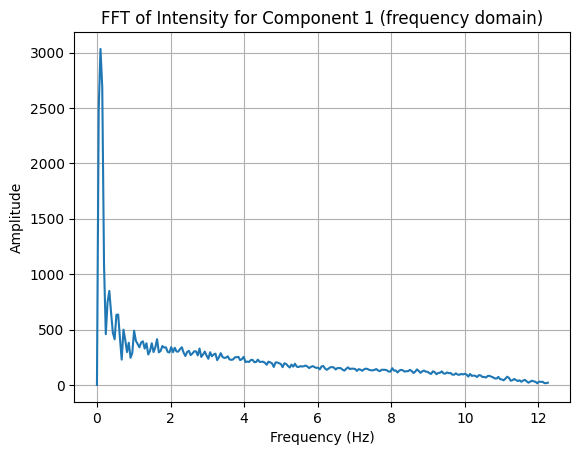

Component 2: Highest Frequency (Hz): 0.04806532118055555


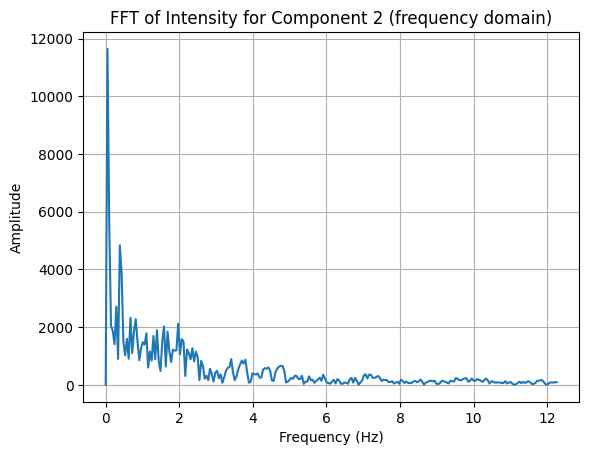

Component 3: Highest Frequency (Hz): 0.04806532118055555


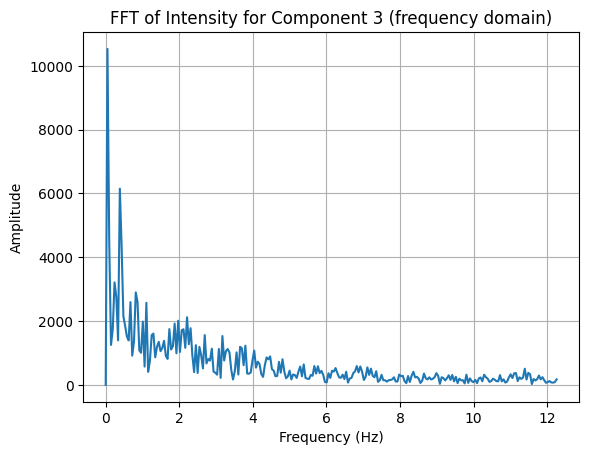

Component 4: Highest Frequency (Hz): 0.04806532118055555


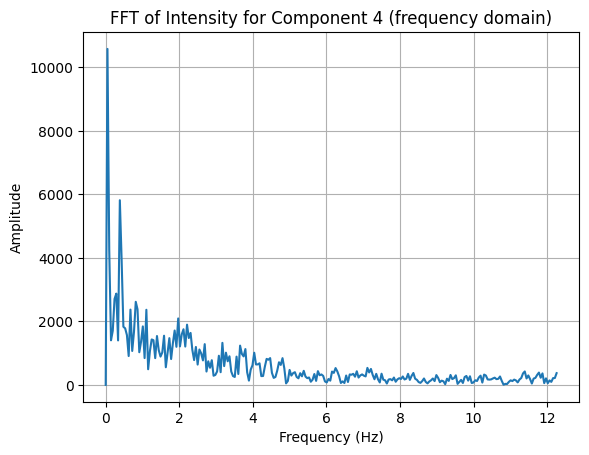

Component 5: Highest Frequency (Hz): 0.04806532118055555


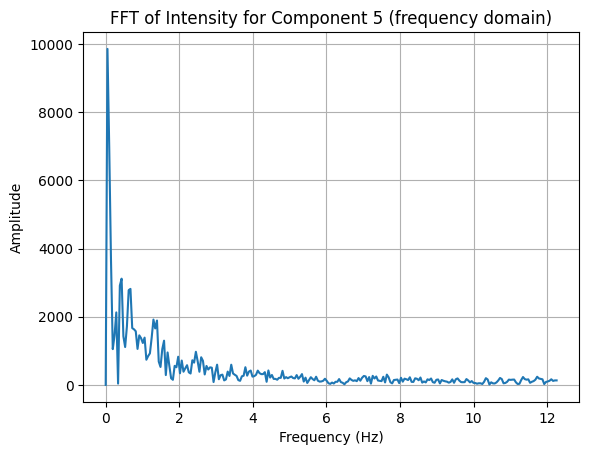

Component 6: Highest Frequency (Hz): 0.04806532118055555


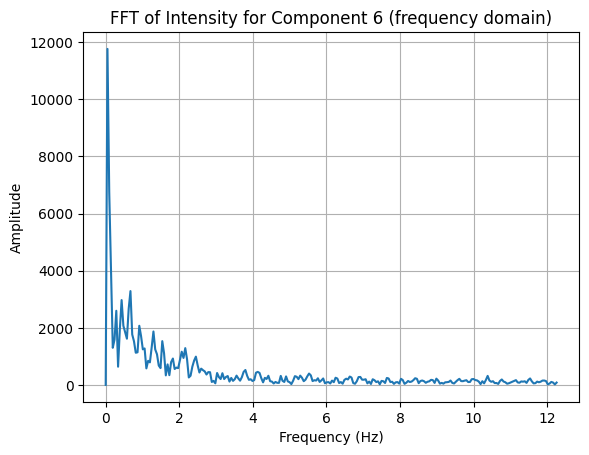

Component 7: Highest Frequency (Hz): 0.04806532118055555


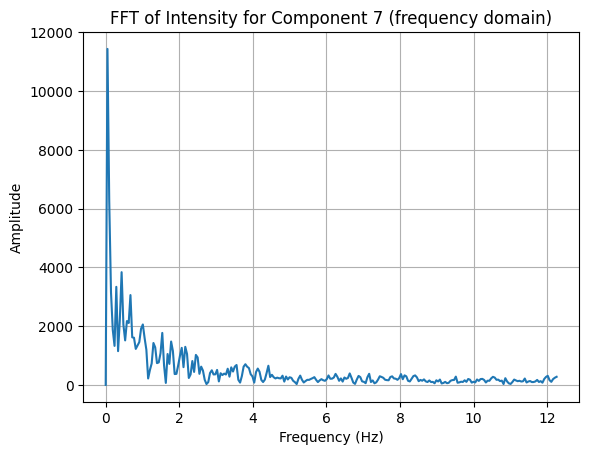

Component 8: Highest Frequency (Hz): 0.04806532118055555


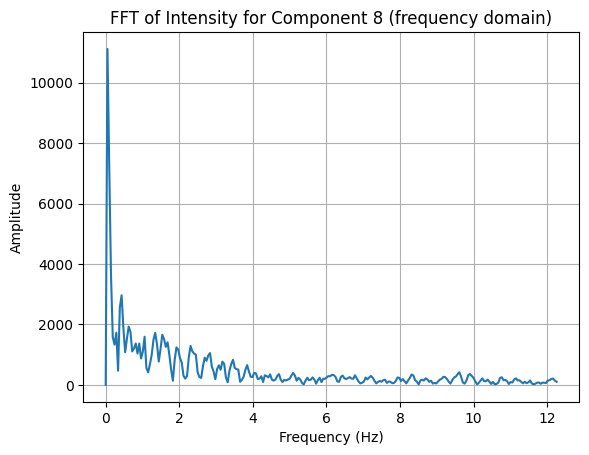

Component 9: Highest Frequency (Hz): 0.04806532118055555


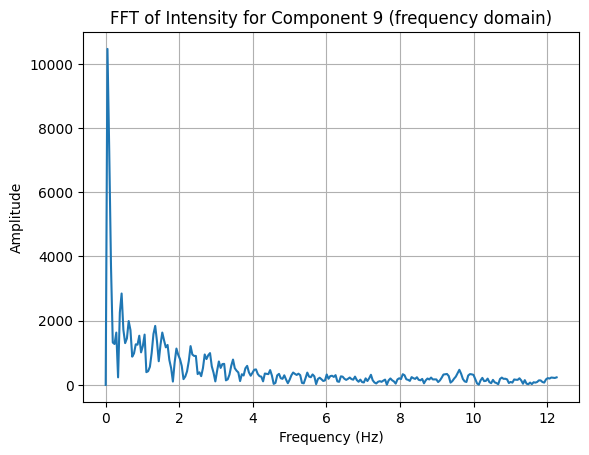

Component 10: Highest Frequency (Hz): 0.04806532118055555


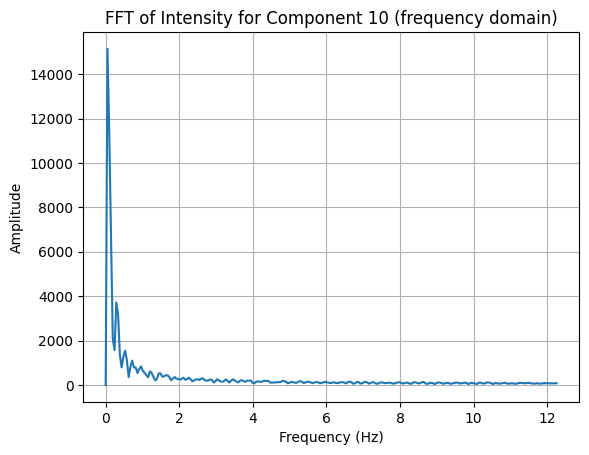

Component 11: Highest Frequency (Hz): 0.04806532118055555


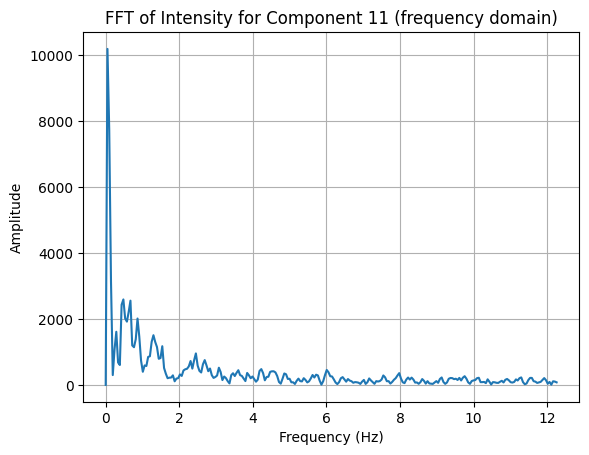

Component 12: Highest Frequency (Hz): 0.04806532118055555


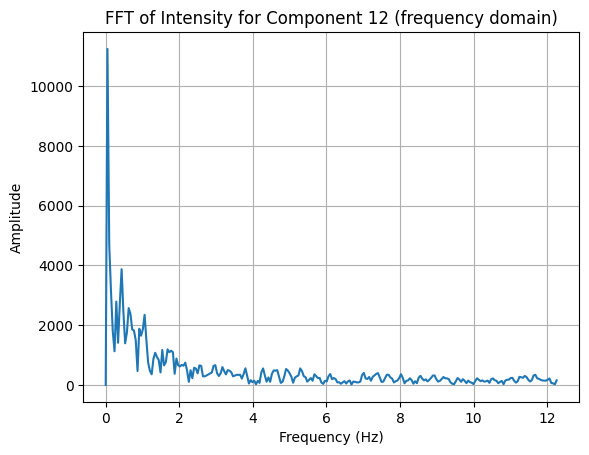

Component 13: Highest Frequency (Hz): 0.04806532118055555


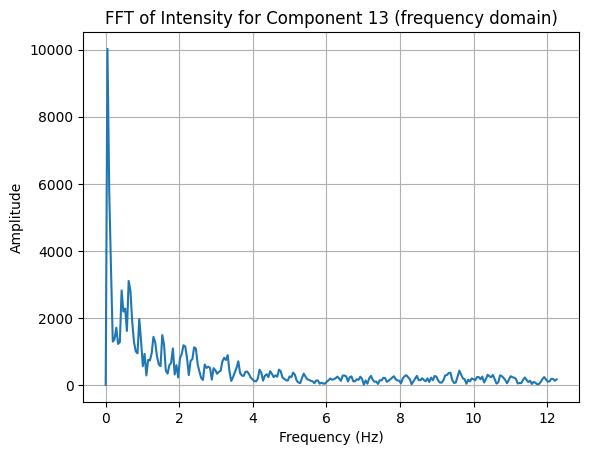

Component 14: Highest Frequency (Hz): 0.04806532118055555


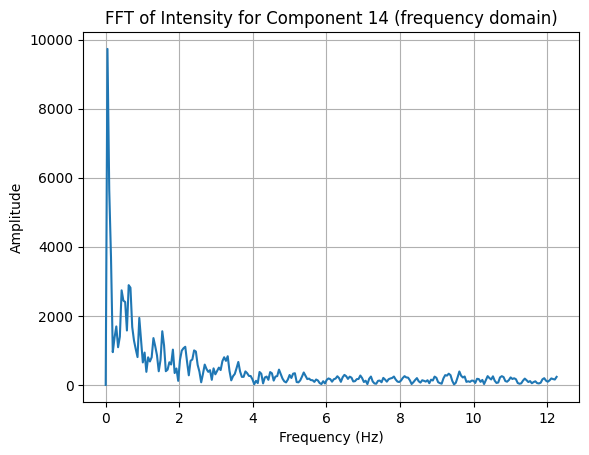

Component 15: Highest Frequency (Hz): 0.04806532118055555


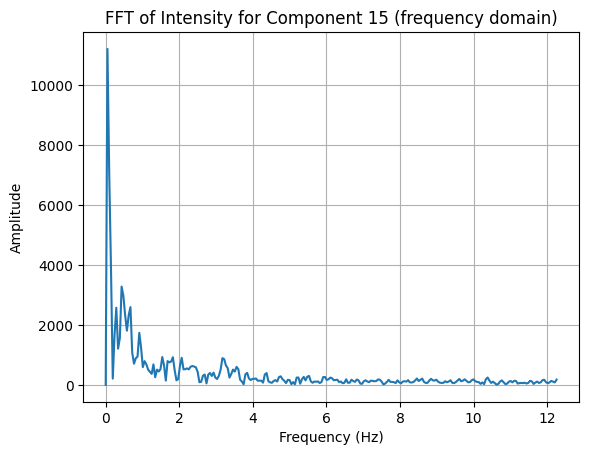

Component 16: Highest Frequency (Hz): 0.04806532118055555


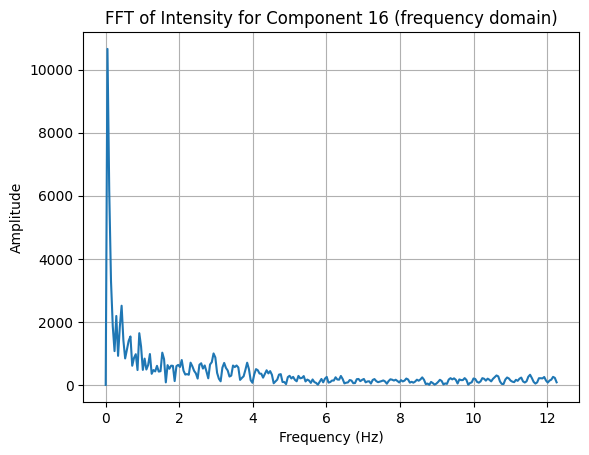

Component 17: Highest Frequency (Hz): 0.04806532118055555


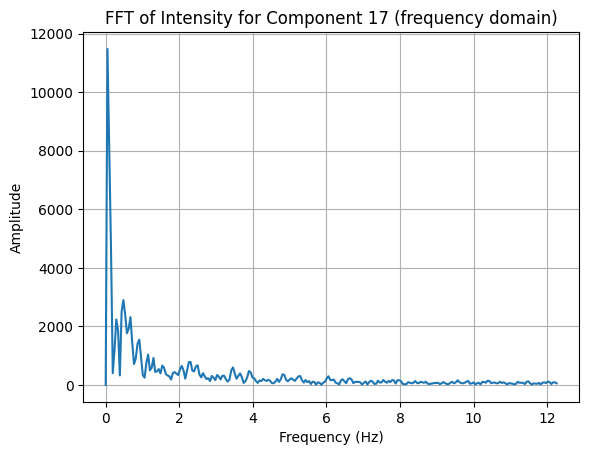

Component 18: Highest Frequency (Hz): 0.04806532118055555


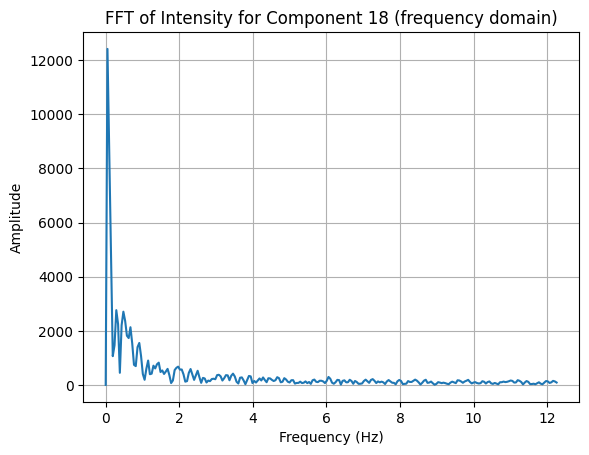

Component 19: Highest Frequency (Hz): 0.04806532118055555


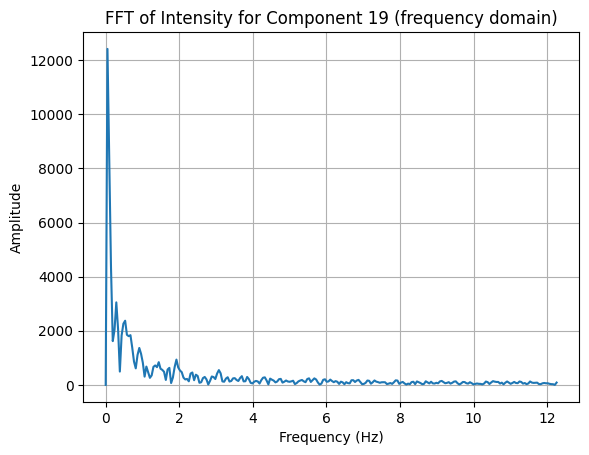

Component 20: Highest Frequency (Hz): 0.0961306423611111


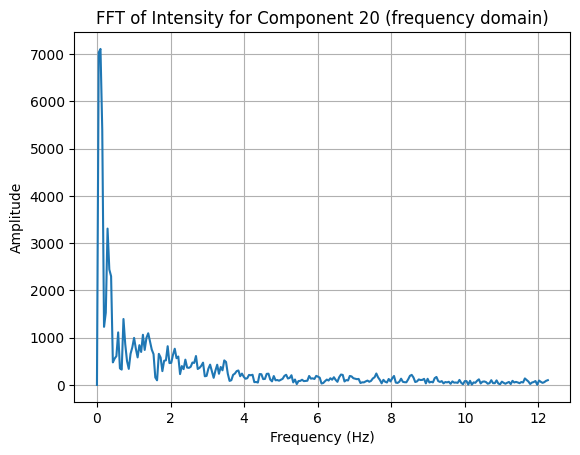

Component 21: Highest Frequency (Hz): 0.04806532118055555


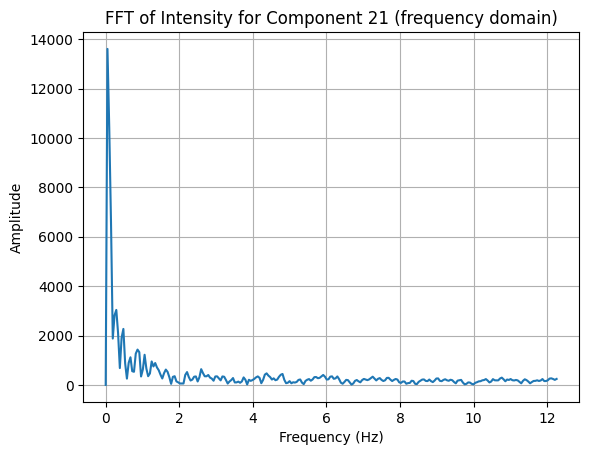

Component 22: Highest Frequency (Hz): 0.04806532118055555


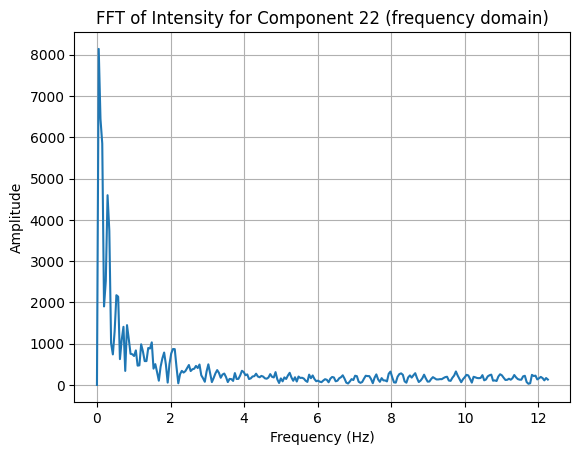

Component 23: Highest Frequency (Hz): 0.04806532118055555


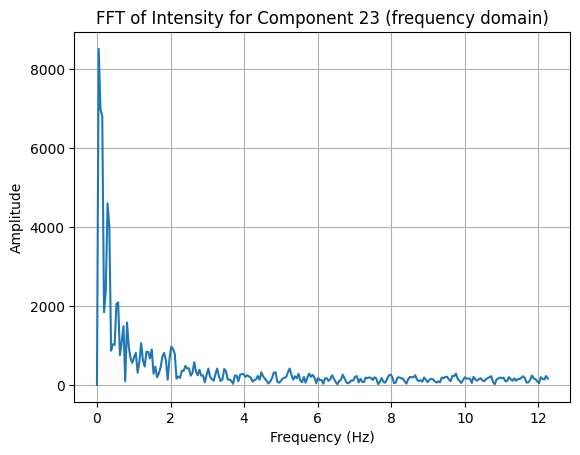

Component 24: Highest Frequency (Hz): 0.04806532118055555


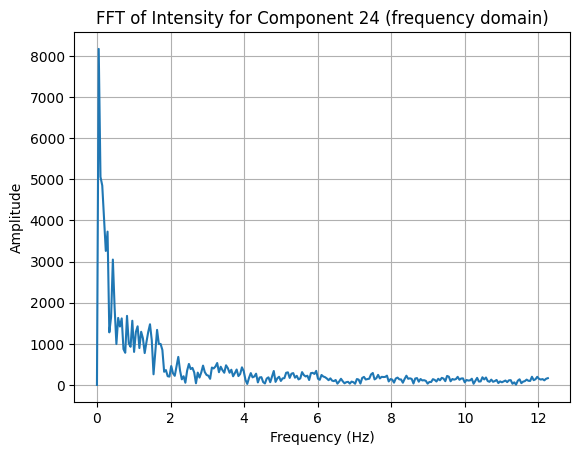

Component 25: Highest Frequency (Hz): 0.04806532118055555


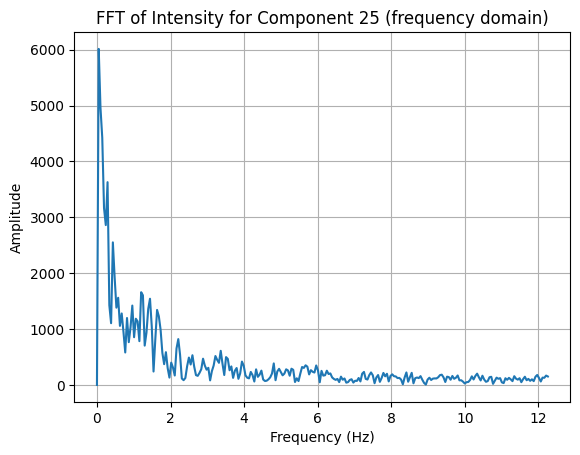

Component 26: Highest Frequency (Hz): 0.04806532118055555


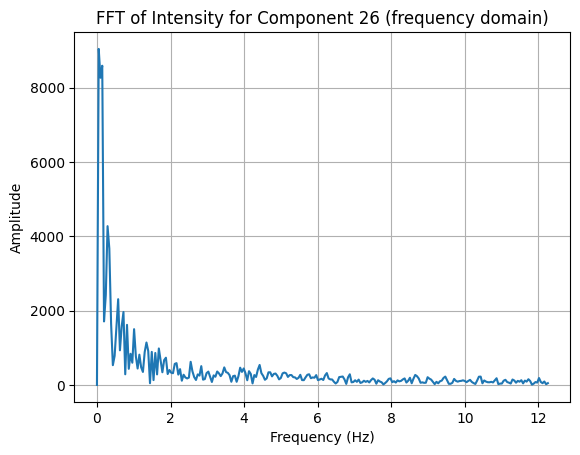

Component 27: Highest Frequency (Hz): 0.04806532118055555


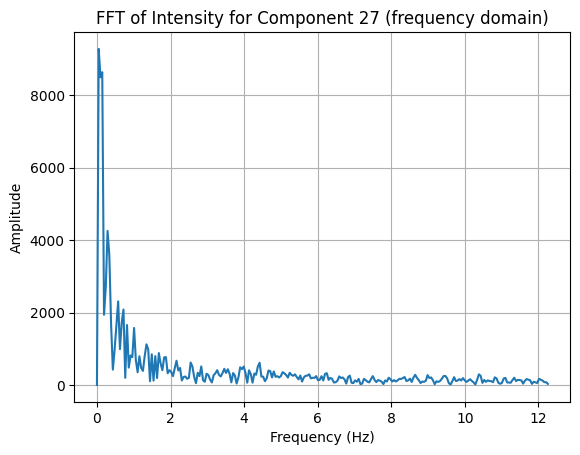

Component 28: Highest Frequency (Hz): 0.04806532118055555


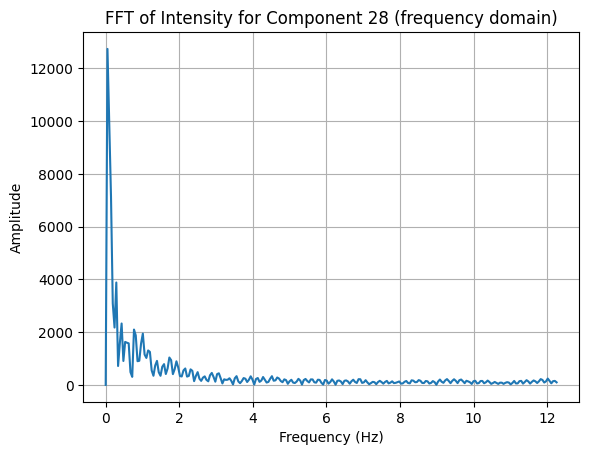

               Frame      label  frequency
0               0 to 511      1   0.096131
1               0 to 511      2   0.048065
2               0 to 511      3   0.048065
3               0 to 511      4   0.048065
4               0 to 511      5   0.048065
5               0 to 511      6   0.048065
6               0 to 511      7   0.048065
7               0 to 511      8   0.048065
8               0 to 511      9   0.048065
9               0 to 511     10   0.048065
10              0 to 511     11   0.048065
11              0 to 511     12   0.048065
12              0 to 511     13   0.048065
13              0 to 511     14   0.048065
14              0 to 511     15   0.048065
15              0 to 511     16   0.048065
16              0 to 511     17   0.048065
17              0 to 511     18   0.048065
18              0 to 511     19   0.048065
19              0 to 511     20   0.096131
20              0 to 511     21   0.048065
21              0 to 511     22   0.048065
22         

In [221]:

if __name__ == "__main__":
    video = '1705951007967.mp4'  
    main(video)
